In [1]:
import numpy as np 
import pandas as pd 

import os

# NLP libraries
import string 
import nltk 
from nltk.corpus import stopwords
import re 

from wordcloud import WordCloud 


import matplotlib.pyplot as plt
import seaborn as sns

# MLlibraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [2]:
train=pd.read_csv(r"C:\Users\hi\Desktop\New folder\py\nlp-getting-started\train.csv")
test=pd.read_csv(r"C:\Users\hi\Desktop\New folder\py\nlp-getting-started\test.csv")

In [3]:
train.shape

(7613, 5)

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [88]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [89]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [90]:
train.keyword.isna().sum()

61

In [49]:
train.location.isna().sum()

2533

In [9]:
Real_len = train[train['target'] == 1].shape[0]
Not_len = train[train['target'] == 0].shape[0]

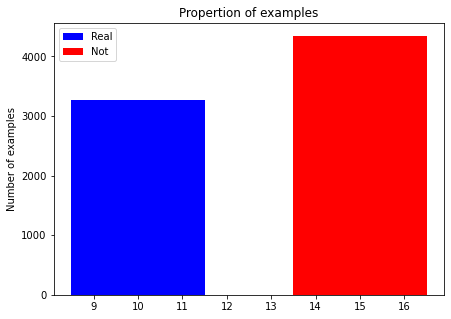

In [10]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,Real_len,3, label="Real", color='blue')
plt.bar(15,Not_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [11]:
def length(string):    
    return len(string)
train['length'] = train['text'].apply(length)

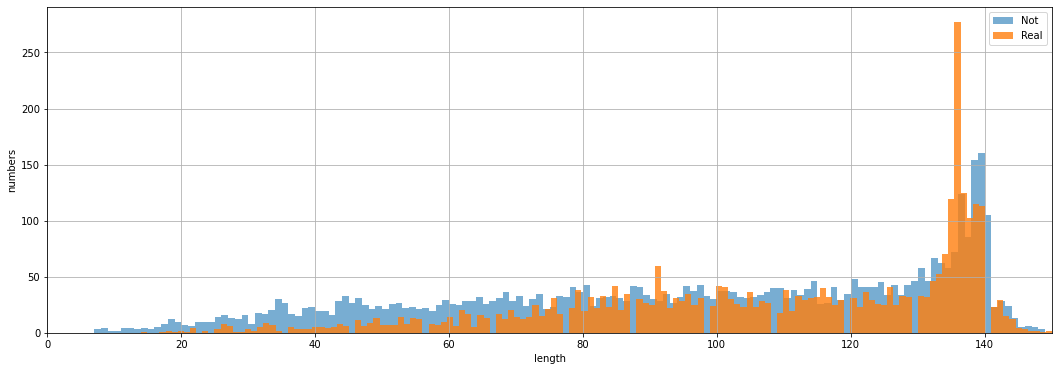

In [12]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(train[train['target'] == 0]['length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(train[train['target'] == 1]['length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

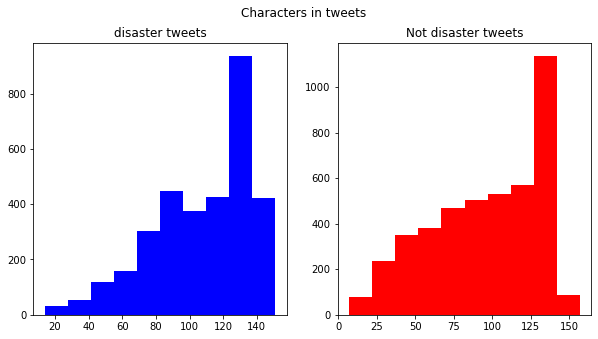

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='red')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

eda

In [14]:
#how many times each keyword showing in the dataset
kw = train.keyword.value_counts().head(10).reset_index()
kw.columns=['keyword','frequency']

In [15]:
#how many times each location showing in the dataset
loc = train.location.value_counts().head(10).reset_index()
loc.columns=['location','frequency']

In [16]:
def plot_frequency(data,title):
    plt.figure(figsize=(10,6))
    plt.title('Most Frequent '+title,fontsize=20,fontweight='bold', pad=20)
    sns.barplot(x=title,y='frequency',data=data,palette='Set2')


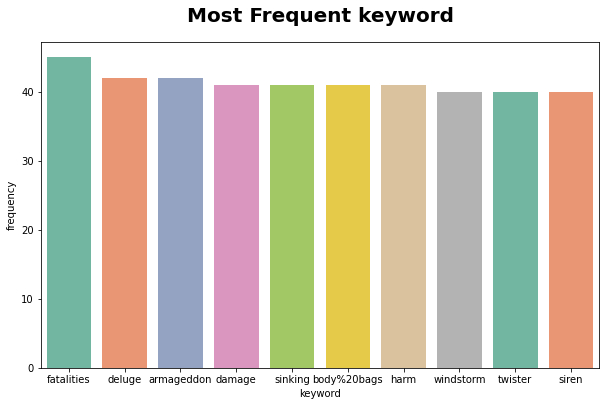

In [17]:
plot_frequency(kw,'keyword')

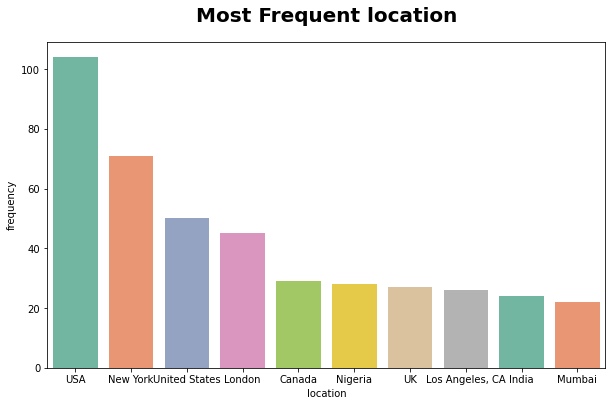

In [18]:
plot_frequency(loc,'location')

In [19]:
locations= train["location"].value_counts().sort_values(ascending=False)
locations_df= pd.DataFrame(dict(zip(locations.index, locations.values)), index=[0]).\
                                melt(var_name="location", value_name="unique_counts")
locations_df.loc[:10]

,location,unique_counts
0,USA,104
1,New York,71
2,United States,50
3,London,45
4,Canada,29
5,Nigeria,28
6,UK,27
7,"Los Angeles, CA",26
8,India,24
9,Mumbai,22


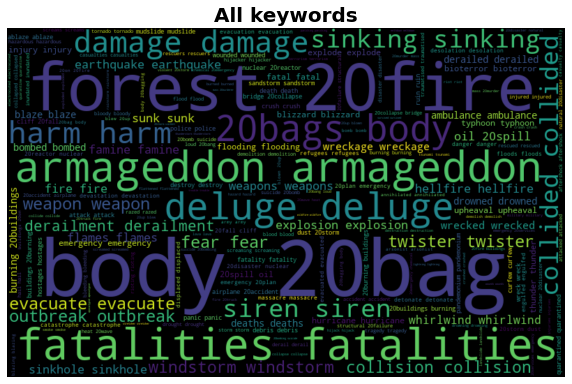

In [20]:
all_keywords = " ".join([keyword for keyword in train["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

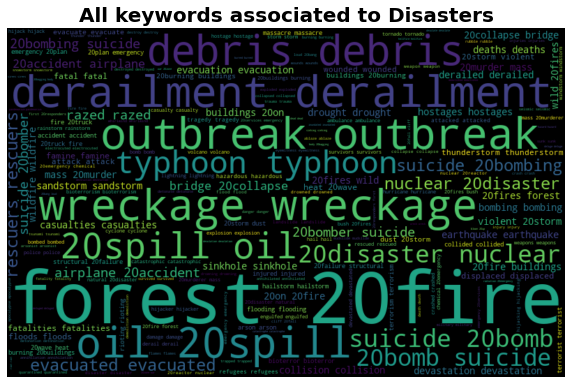

In [21]:
all_disaster_keywords = " ".join([keyword for keyword in train[train["target"]==1]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_disaster_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords associated to Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

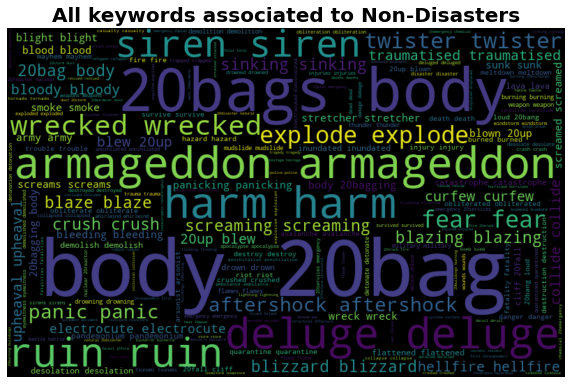

In [22]:
# all keywords from tweets NOT associated to disaster
all_non_disaster_keywords = " ".join([keyword for keyword in train[train["target"]==0]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_non_disaster_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords associated to Non-Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
train.keyword.nunique()

221

data cleaning

In [4]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [5]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x : clean_text(x))

In [6]:
train['text'].head()

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3     people receive wildfires evacuation orders in...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [7]:
test['text'].head()

0                   just happened a terrible car crash
1    heard about earthquake is different cities sta...
2    there is a forest fire at spot pond geese are ...
3                apocalypse lighting spokane wildfires
4          typhoon soudelor kills  in china and taiwan
Name: text, dtype: object

tokkenizer

In [8]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

In [9]:
train['text'].head()

0    [our, deeds, are, the, reason, of, this, earth...
1        [forest, fire, near, la, ronge, sask, canada]
2    [all, residents, asked, to, shelter, in, place...
3    [people, receive, wildfires, evacuation, order...
4    [just, got, sent, this, photo, from, ruby, ala...
Name: text, dtype: object

In [10]:
test['text'].head()

0            [just, happened, a, terrible, car, crash]
1    [heard, about, earthquake, is, different, citi...
2    [there, is, a, forest, fire, at, spot, pond, g...
3           [apocalypse, lighting, spokane, wildfires]
4    [typhoon, soudelor, kills, in, china, and, tai...
Name: text, dtype: object

remove stopwords

In [11]:
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x : remove_stopwords(x))
test['text'] = test['text'].apply(lambda x : remove_stopwords(x))

In [12]:
train['text'].head()

0    [deeds, reason, earthquake, may, allah, forgiv...
1        [forest, fire, near, la, ronge, sask, canada]
2    [residents, asked, shelter, place, notified, o...
3    [people, receive, wildfires, evacuation, order...
4    [got, sent, photo, ruby, alaska, smoke, wildfi...
Name: text, dtype: object

In [13]:
test['text'].head()

0                     [happened, terrible, car, crash]
1    [heard, earthquake, different, cities, stay, s...
2    [forest, fire, spot, pond, geese, fleeing, acr...
3           [apocalypse, lighting, spokane, wildfires]
4            [typhoon, soudelor, kills, china, taiwan]
Name: text, dtype: object

In [14]:
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x : combine_text(x))
test['text'] = test['text'].apply(lambda x : combine_text(x))

In [15]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


In [16]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake different cities stay safe ev...
2,3,NaN,NaN,forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills china taiwan


In [15]:
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

In [20]:









df=pd.concat([train,test])

In [21]:
df.drop(['keyword','location'],axis=1)

,id,text,target
0,1,deeds reason earthquake may allah forgive us,1.0
1,4,forest fire near la ronge sask canada,1.0
2,5,residents asked shelter place notified officer...,1.0
3,6,people receive wildfires evacuation orders cal...,1.0
4,7,got sent photo ruby alaska smoke wildfires pou...,1.0
...,...,...,...
3258,10861,earthquake safety los angeles ûò safety fasten...,NaN
3259,10865,storm ri worse last hurricane hardest hit yard...,NaN
3260,10868,green line derailment chicago,NaN
3261,10874,meg issues hazardous weather outlook hwo,NaN


In [20]:
X= train.drop(['target'], axis=1)
y = train['target']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=2)

In [23]:
x_train.head()

,id,keyword,location,text
2466,3534,derailment,Mumbai,latest trains derailment freakiest freak accid...
3670,5224,fatality,Rafael castillo,fatality
6836,9791,trapped,"St Louis, MO",boyinahorsemask panda trapped dogs body
524,758,avalanche,NaN,patrick roy upper deck spx finite made colorad...
3640,5189,fatalities,"Nantes, France",estimated damage fatalities hiroshimasized ato...


In [21]:
vectorizer = TfidfVectorizer()
tf_idf_data_train = vectorizer.fit_transform(train.text)

tf_idf_data_test = vectorizer.transform(test.text)

In [22]:
y_train=train['target']

model

In [24]:
from sklearn.metrics import classification_report
#logistic regression
model = LogisticRegression(C=1,penalty='l2')
model.fit(tf_idf_data_train,y_train)
y_pred = model.predict(tf_idf_data_test)

In [25]:
pred = model.predict(tf_idf_data_test)
pred = pd.Series(pred)
ids = pd.Series(test['id'])

pred_df = pd.concat([ids, pred], keys = ['id', 'target'], axis = 1)

pred_df.to_csv('sub1.csv',index = False)

In [83]:
print("Acuracy", accuracy_score(tf_idf_data_test, pred))

TypeError: len() of unsized object

In [42]:
#naviebayes
#Gaussian Naive Bayes
model = GaussianNB()
model.fit(tf_idf_data_train.toarray(),y_train)
y_pred = model.predict(tf_idf_data_test.toarray())
print("Acuracy", accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('f1 score',f1_score(y_test, y_pred))
print('confusion_matrix',confusion_matrix(y_test, y_pred))

Acuracy 0.5942219304005253
precision 0.5188374596340151
recall 0.7381316998468607
f1 score 0.6093552465233881
confusion_matrix [[423 447]
 [171 482]]


In [46]:
from sklearn.metrics import classification_report
#Bernoulli Naive Bayes
model = BernoulliNB()
model.fit(tf_idf_data_train.toarray(),y_train)
y_pred = model.predict(tf_idf_data_test.toarray())
cr1=classification_report(y_test, y_pred)
print(cr1)
print("Acuracy", accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('f1 score',f1_score(y_test, y_pred))
print('confusion_matrix',confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.91      0.84       870
           1       0.85      0.65      0.73       653

    accuracy                           0.80      1523
   macro avg       0.81      0.78      0.79      1523
weighted avg       0.81      0.80      0.79      1523

Acuracy 0.7984241628365069
precision 0.8473895582329317
recall 0.6462480857580398
f1 score 0.733275412684622
confusion_matrix [[794  76]
 [231 422]]


In [45]:
#Multinomial Naive Bayes
model = MultinomialNB()
model.fit(tf_idf_data_train.toarray(),y_train)
y_pred = model.predict(tf_idf_data_test.toarray())
print("Acuracy", accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('f1 score',f1_score(y_test, y_pred))
print('confusion_matrix',confusion_matrix(y_test, y_pred))

Acuracy 0.7951411687458962
precision 0.8272552783109405
recall 0.6600306278713629
f1 score 0.7342419080068143
confusion_matrix [[780  90]
 [222 431]]


In [46]:
#Support Vector Machines (SVM)
#RBF Kernel SVM
model=svm.SVC(kernel='rbf')
model.fit(tf_idf_data_train,y_train)
y_pred = model.predict(tf_idf_data_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('f1 score',f1_score(y_test, y_pred))
print('confusion_matrix',confusion_matrix(y_test, y_pred))

Acuracy 0.7957977675640184
precision 0.8489795918367347
recall 0.6370597243491577
f1 score 0.7279090113735781
confusion_matrix [[796  74]
 [237 416]]


In [47]:
#Linear Kernel SVM
model=svm.SVC(kernel='linear')
model.fit(tf_idf_data_train,y_train)
y_pred = model.predict(tf_idf_data_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('f1 score',f1_score(y_test, y_pred))
print('confusion_matrix',confusion_matrix(y_test, y_pred))

Acuracy 0.7977675640183848
precision 0.8096947935368043
recall 0.6906584992343032
f1 score 0.7454545454545455
confusion_matrix [[764 106]
 [202 451]]


In [48]:
#Linear Kernel SVM
model=svm.SVC()
model.fit(tf_idf_data_train,y_train)
y_pred = model.predict(tf_idf_data_test)

print("Acuracy", accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('f1 score',f1_score(y_test, y_pred))
print('confusion_matrix',confusion_matrix(y_test, y_pred))

Acuracy 0.7957977675640184
precision 0.8489795918367347
recall 0.6370597243491577
f1 score 0.7279090113735781
confusion_matrix [[796  74]
 [237 416]]


In [49]:
#Random Forest
model = RandomForestClassifier(random_state=0)
model.fit(tf_idf_data_train,y_train)
y_pred = model.predict(tf_idf_data_test)
print("Acuracy", accuracy_score(y_test, y_pred))
print('precision',precision_score(y_test, y_pred))
print('recall',recall_score(y_test, y_pred))
print('f1 score',f1_score(y_test, y_pred))
print('confusion_matrix',confusion_matrix(y_test, y_pred))

Acuracy 0.7852921864740644
precision 0.7963636363636364
recall 0.6707503828483921
f1 score 0.7281795511221945
confusion_matrix [[758 112]
 [215 438]]


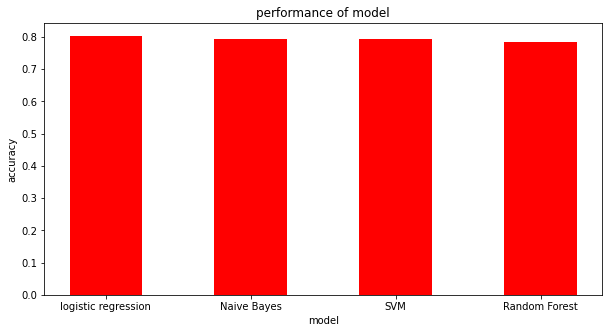

In [50]:
data={'logistic regression':0.803,'Naive Bayes':0.795,
      'SVM':0.795,'Random Forest':0.785}
model=list(data.keys())
accuracy=list(data.values())
fig=plt.figure(figsize=(10,5))
plt.bar(model,accuracy,color='red',width=0.5)
plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('performance of model')
plt.show()

In [ ]:
data={'logistic regression':0.803,'Gaussian Naive Bayes':0.594,
      'Bernoulli Naive Bayes':0.798,'Multinomial Naive Bayes':0.795,
      'SVM':0.795,'Random Forest':0.785}
model=list(data.keys())
accuracy=list(data.values())
fig=plt.figure(figsize=(10,5))
plt.bar(model,accuracy,color='red',width=0.5)
plt.xlabel('model')
plt.ylabel('accuracy')
plt.title('performance of model')
plt.show()